# Import Libraries

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

# Parameters

## Path and filename of the dataset

In [102]:
DATA_PATH = "./data/"
FILE_NAME = 'DP980Y700_SDG3_2021_extended.csv'

## Neural Network parameters

In [103]:
EPOCHS = 10000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Load and read data

## Import the Dataset

In [104]:
df = pd.read_csv(DATA_PATH + FILE_NAME, delimiter =";", decimal=",")
df.head()

,Coilnr,Date,Direction,Th mm,Re02 Mpa,Rm Mpa,A80 x10%,n x1000,r x100,Re/Rm,...,After Soaking P3(C),After rapid cooling P4(C),Linespeed (m/min),Zink bottom (gr/m2),Zink top (gr/m2),SKP elongation (%),SKP Pressure (kN),C/s P1/P2,C/s P2/P3,C/s P3/P4
0,41971853,06-01-21,L,1.92,791,1058,107,63,68,75,...,800.987915,487.601574,51.922714,55.509306,54.877287,0.395166,8271.445498,1.223472,0.045591,-13.559891
1,41943566,08-01-21,L,1.01,690,1029,114,77,65,67,...,806.446350,497.245289,130.468628,60.863074,53.569768,0.453954,8263.117895,2.537354,0.113249,-33.617532
2,42071675,09-01-21,L,1.62,796,1037,106,60,67,77,...,818.309815,484.193967,78.013863,53.647423,53.234872,0.394861,7390.691312,1.634436,0.137986,-21.721390
3,42071668,09-01-21,L,1.62,745,1036,105,64,64,72,...,818.166443,481.330018,76.819946,53.221745,53.219945,0.394584,7435.146814,1.611650,0.092550,-21.563130
4,42071705,10-01-21,L,1.92,776,1006,95,62,68,77,...,796.503906,481.701958,63.891125,51.919579,54.494145,0.452333,6744.308326,1.550988,-0.254067,-16.760875


## Pre-process the dataset

In [105]:
filters = df[["Date", "Direction","Re/Rm"]]
target_re02 = df[["Re02 Mpa"]]
target_rm = df[["Rm Mpa"]]
target_A = df[["A80 x10%"]]

# The input variables are removed from the 'df' dataframe:
# - date, direction and ratio Re/Rm (filters)
# - elastic resistance (target_re02)
# - mechanical resistance (target_rm)
# - elongation (target_A)

# After removing unnecessary variables, the 'features' dataframe contains :
# 31 variables and 642 examples

features = df.drop(target_A + target_re02 + target_rm + filters ,axis=1)

# Model PYTORCH

## Dataloader

In [106]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## Neural Network

In [107]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features, num_hidden_neuron):
        super(MultipleRegression, self).__init__()
        # Input layer to the hidden layer
        self.layer_1 = nn.Linear(num_features, num_hidden_neuron)
        # Hidden layer to the output layer
        self.layer_out= nn.Linear(num_hidden_neuron, 1)        
        
    # Method called when learning the MLP. 
    # The activation functions of the neurons in the hidden layer are sigmoid. 
    # The neuron of the output layer neuron has a linear activation function
    def forward(self, inputs):
        x = torch.sigmoid(self.layer_1(inputs))
        x = self.layer_out(x)
        return (x)
        
    # Method called during test
    def predict(self, test_inputs):
        x = torch.sigmoid(self.layer_1(test_inputs))
        x = self.layer_out(x)
        return (x)

## Selection of the device for training

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Processing of the dataset

In [109]:
#---------------------------------------------------------------------------------------------
# Learning and testing basis for mechanical resistance
# For the time being no validation basis is used
#---------------------------------------------------------------------------------------------
# We are creating a learning and testing base to estimate the mechanical resistance
X_train_rm, X_test_rm, Y_train_rm, Y_test_rm = train_test_split(features, target_rm, test_size=0.20, random_state=0)
Y_train_rm = Y_train_rm.values.ravel()
Y_test_rm = Y_test_rm.values.ravel()

# An object of type MinMaxScaler is defined: useful for normalizing data
scaler_rm = MinMaxScaler()
scaler_re02 = MinMaxScaler()
scaler_A = MinMaxScaler()

# The training and test bases Xtrain_rm and X_test_rm are normalized. These variables are of type numpy.ndarray
X_train_rm = scaler_rm.fit_transform(X_train_rm)
y_train_rm = Y_train_rm
X_test_rm = scaler_rm.transform(X_test_rm)
y_test_rm = Y_test_rm


# A priori these 2 instructions are useless
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_test, y_test = np.array(X_test), np.array(y_test)

#---------------------------------------------------------------------------------------------
# Learning and testing basis for elastic resilience
#---------------------------------------------------------------------------------------------

X_train_re02,X_test_re02,Y_train_re02,Y_test_re02 = train_test_split(features,target_re02,test_size=0.20,random_state=0)
Y_train_re02 = Y_train_re02.values.ravel()
Y_test_re02 = Y_test_re02.values.ravel()

# The training and test bases Xtrain_re02 and X_test_re02 are normalized. These variables are of type numpy.ndarray
X_train_re02 = scaler_re02.fit_transform(X_train_re02)
y_train_re02 = Y_train_re02
X_test_re02 = scaler_re02.transform(X_test_re02)
y_test_re02 = Y_test_re02

#---------------------------------------------------------------------------------------------
# Learning and testing basis for lengthening
#---------------------------------------------------------------------------------------------
X_train_A,X_test_A,Y_train_A,Y_test_A = train_test_split(features,target_A,test_size=0.20,random_state=0)
Y_train_A = Y_train_A.values.ravel()
Y_test_A = Y_test_A.values.ravel()

# The training and test bases Xtrain_A and X_test_A are normalized. These variables are of type numpy.ndarray
X_train_A = scaler_A.fit_transform(X_train_A)
y_train_A = Y_train_A
X_test_A = scaler_A.transform(X_test_A)
y_test_A = Y_test_A


# The dimensions of the tables containing the training and test data are displayed
print(X_train_rm.shape, X_test_rm.shape, Y_train_rm.shape, Y_test_rm.shape)

# Objects of type RegressionDataSet are created for the learning base and the test base
train_dataset_rm = RegressionDataset(torch.from_numpy(X_train_rm).float(), torch.from_numpy(y_train_rm).float())
test_dataset_rm = RegressionDataset(torch.from_numpy(X_test_rm).float(), torch.from_numpy(y_test_rm).float())

train_dataset_re02 = RegressionDataset(torch.from_numpy(X_train_re02).float(), torch.from_numpy(y_train_re02).float())
test_dataset_re02 = RegressionDataset(torch.from_numpy(X_test_re02).float(), torch.from_numpy(y_test_re02).float())

train_dataset_A = RegressionDataset(torch.from_numpy(X_train_A).float(), torch.from_numpy(y_train_A).float())
test_dataset_A = RegressionDataset(torch.from_numpy(X_test_A).float(), torch.from_numpy(y_test_A).float())

(513, 35) (129, 35) (513,) (129,)


## Train the neural network

## Dataloarder, optimizer, criterion

In [110]:
# Define dataloaders
train_loader_rm = DataLoader(dataset=train_dataset_rm, batch_size=BATCH_SIZE, shuffle=True)
test_loader_rm = DataLoader(dataset=test_dataset_rm, batch_size=1)
train_loader_re02 = DataLoader(dataset=train_dataset_re02, batch_size=BATCH_SIZE, shuffle=True)
test_loader_re02 = DataLoader(dataset=test_dataset_re02, batch_size=1)
train_loader_A = DataLoader(dataset=train_dataset_A, batch_size=BATCH_SIZE, shuffle=True)
test_loader_A = DataLoader(dataset=test_dataset_A, batch_size=1)

NUM_FEATURES = X_train_rm.shape[1]

# Define models, one for each regressor
model_rm = MultipleRegression(NUM_FEATURES, 50)
model_re02 = MultipleRegression(NUM_FEATURES, 50)
model_A = MultipleRegression(NUM_FEATURES, 50)

# Attach each model to the device
model_rm.to(device)
model_re02.to(device)
model_A.to(device)

print("Model for Rm regression: ", model_rm)
print("Model for Re02 regression: ", model_rm)
print("Model for A regression: ", model_rm)

criterion_rm = nn.MSELoss()
criterion_re02 = nn.MSELoss()
criterion_A = nn.MSELoss()

optimizer_rm = optim.Adam(model_rm.parameters(), lr=LEARNING_RATE)
optimizer_re02 = optim.Adam(model_re02.parameters(), lr=LEARNING_RATE)
optimizer_A = optim.Adam(model_A.parameters(), lr=LEARNING_RATE)

loss_stats = {
    'train': [],
    "val": []
}

Model for Rm regression:  MultipleRegression(
  (layer_1): Linear(in_features=35, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=1, bias=True)
)
Model for Re02 regression:  MultipleRegression(
  (layer_1): Linear(in_features=35, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=1, bias=True)
)
Model for A regression:  MultipleRegression(
  (layer_1): Linear(in_features=35, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=1, bias=True)
)


## Train and Test for $R_m$

In [111]:
# Training of MLP Rm
print("Start training for Rm")
for e in tqdm(range(1, EPOCHS+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model_rm.train()
        for X_train_batch, y_train_batch in train_loader_rm:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer_rm.zero_grad()
        
            y_train_pred = model_rm(X_train_batch)
        
            train_loss = criterion_rm(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer_rm.step()
        
            train_epoch_loss += train_loss.item()
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader_rm):.5f} ')

# Evaluation of the Rm model
y_pred_list_rm = []
with torch.no_grad():
    model_rm.eval()
    for X_batch, _ in test_loader_rm:
        X_batch = X_batch.to(device)
        y_test_pred = model_rm(X_batch)
        y_pred_list_rm.append(y_test_pred.cpu().numpy())

y_pred_list_rm = [a.squeeze().tolist() for a in y_pred_list_rm]

Start training for Rm


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1053102.20833 
Epoch 002: | Train Loss: 1057297.32639 
Epoch 003: | Train Loss: 1049123.15972 
Epoch 004: | Train Loss: 1046139.37500 
Epoch 005: | Train Loss: 1043829.13889 
Epoch 006: | Train Loss: 1045366.36806 
Epoch 007: | Train Loss: 1042598.42361 
Epoch 008: | Train Loss: 1034293.77083 
Epoch 009: | Train Loss: 1040159.11806 
Epoch 010: | Train Loss: 1029910.34722 
Epoch 011: | Train Loss: 1039601.91667 
Epoch 012: | Train Loss: 1037170.95139 
Epoch 013: | Train Loss: 1034974.20833 
Epoch 014: | Train Loss: 1033826.32639 
Epoch 015: | Train Loss: 1031986.12500 
Epoch 016: | Train Loss: 1028985.36806 
Epoch 017: | Train Loss: 1035113.57639 
Epoch 018: | Train Loss: 1035179.79167 
Epoch 019: | Train Loss: 1024823.97917 
Epoch 020: | Train Loss: 1041790.28472 
Epoch 021: | Train Loss: 1029485.85417 
Epoch 022: | Train Loss: 1026510.47222 
Epoch 023: | Train Loss: 1024718.90972 
Epoch 024: | Train Loss: 1016766.90278 
Epoch 025: | Train Loss: 1020294.59722 


## Train and Test for $R_{e,0.2\%}$

In [112]:
# Training of MLP Re02
print("Start training for Re02")
for e in tqdm(range(1, EPOCHS+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model_re02.train()
        for X_train_batch, y_train_batch in train_loader_re02:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer_re02.zero_grad()
        
            y_train_pred = model_re02(X_train_batch)
        
            train_loss = criterion_re02(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer_re02.step()
        
            train_epoch_loss += train_loss.item()
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader_re02):.5f} ')
        
# Evaluation of the Re model
y_pred_list_re02 = []
with torch.no_grad():
    model_re02.eval()
    for X_batch, _ in test_loader_re02:
        X_batch = X_batch.to(device)
        y_test_pred = model_re02(X_batch)
        y_pred_list_re02.append(y_test_pred.cpu().numpy())

y_pred_list_re02 = [a.squeeze().tolist() for a in y_pred_list_re02]

Start training for Re02


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 561866.56944 
Epoch 002: | Train Loss: 567811.14583 
Epoch 003: | Train Loss: 578240.56944 
Epoch 004: | Train Loss: 558885.12500 
Epoch 005: | Train Loss: 558631.42708 
Epoch 006: | Train Loss: 574160.26389 
Epoch 007: | Train Loss: 574965.27778 
Epoch 008: | Train Loss: 567689.31250 
Epoch 009: | Train Loss: 577608.93750 
Epoch 010: | Train Loss: 559858.90625 
Epoch 011: | Train Loss: 559891.61458 
Epoch 012: | Train Loss: 559553.38194 
Epoch 013: | Train Loss: 571501.62500 
Epoch 014: | Train Loss: 552572.74653 
Epoch 015: | Train Loss: 566965.20833 
Epoch 016: | Train Loss: 559476.72569 
Epoch 017: | Train Loss: 566943.12500 
Epoch 018: | Train Loss: 570560.84028 
Epoch 019: | Train Loss: 555364.48264 
Epoch 020: | Train Loss: 562383.02778 
Epoch 021: | Train Loss: 568593.90972 
Epoch 022: | Train Loss: 557699.86111 
Epoch 023: | Train Loss: 565122.64583 
Epoch 024: | Train Loss: 544113.65278 
Epoch 025: | Train Loss: 569043.43056 
Epoch 026: | Train Loss: 

## Train and Test for $A_{\%}$

In [113]:
# Training of MLP A%
print("Start training for A")
for e in tqdm(range(1, EPOCHS+1)):
    
        # TRAINING
        train_epoch_loss = 0
        model_A.train()
        for X_train_batch, y_train_batch in train_loader_A:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer_A.zero_grad()
        
            y_train_pred = model_A(X_train_batch)
        
            train_loss = criterion_A(y_train_pred, y_train_batch.unsqueeze(1))
        
            train_loss.backward()
            optimizer_A.step()
        
            train_epoch_loss += train_loss.item()
        
        print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader_A):.5f} ')
# Evaluation of the A% model
y_pred_list_A = []
with torch.no_grad():
    model_A.eval()
    for X_batch, _ in test_loader_A:
        X_batch = X_batch.to(device)
        y_test_pred = model_A(X_batch)
        y_pred_list_A.append(y_test_pred.cpu().numpy())

y_pred_list_A = [a.squeeze().tolist() for a in y_pred_list_A]

Start training for A


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 9996.51004 
Epoch 002: | Train Loss: 10097.53103 
Epoch 003: | Train Loss: 10280.69933 
Epoch 004: | Train Loss: 10728.97146 
Epoch 005: | Train Loss: 10411.64605 
Epoch 006: | Train Loss: 10015.04080 
Epoch 007: | Train Loss: 9820.06554 
Epoch 008: | Train Loss: 10027.97645 
Epoch 009: | Train Loss: 9175.83198 
Epoch 010: | Train Loss: 9644.71224 
Epoch 011: | Train Loss: 9808.41580 
Epoch 012: | Train Loss: 9941.27691 
Epoch 013: | Train Loss: 8824.76888 
Epoch 014: | Train Loss: 9173.37750 
Epoch 015: | Train Loss: 9764.21539 
Epoch 016: | Train Loss: 8824.32878 
Epoch 017: | Train Loss: 9271.36372 
Epoch 018: | Train Loss: 8703.81288 
Epoch 019: | Train Loss: 8634.29259 
Epoch 020: | Train Loss: 8726.40679 
Epoch 021: | Train Loss: 7996.99948 
Epoch 022: | Train Loss: 8698.72884 
Epoch 023: | Train Loss: 8312.34663 
Epoch 024: | Train Loss: 8706.51063 
Epoch 025: | Train Loss: 7965.65630 
Epoch 026: | Train Loss: 8221.47607 
Epoch 027: | Train Loss: 7780.02

## Plot results

Then, one shows the results

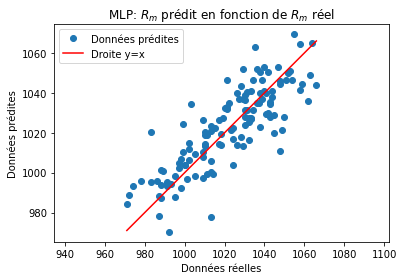

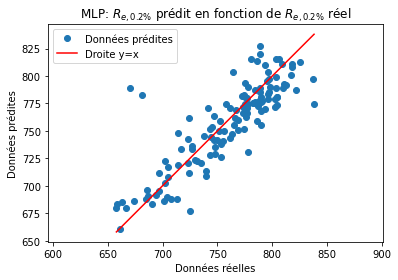

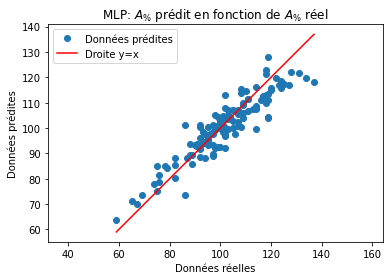

In [114]:
plt.axis('equal')
plt.xlabel("Données réelles")
plt.ylabel("Données prédites")
plt.title("MLP: $R_{m}$ prédit en fonction de $R_{m}$ réel")
plt.plot( y_test_rm, y_pred_list_rm, 'o', label = "Données prédites")
plt.plot([min(y_test_rm),max(y_test_rm)], [min(y_test_rm),max(y_test_rm)], 'r', label = "Droite y=x")

plt.legend()
plt.show()

plt.axis('equal')
plt.xlabel("Données réelles")
plt.ylabel("Données prédites")
plt.title("MLP: $R_{e,0.2\%}$ prédit en fonction de $R_{e,0.2\%}$ réel")
plt.plot( y_test_re02, y_pred_list_re02, 'o', label = "Données prédites")
plt.plot([min(y_test_re02),max(y_test_re02)], [min(y_test_re02),max(y_test_re02)], 'r', label = "Droite y=x")

plt.legend()
plt.show()

plt.axis('equal')
plt.xlabel("Données réelles")
plt.ylabel("Données prédites")
plt.title("MLP: $A_{\%}$ prédit en fonction de $A_{\%}$ réel")
plt.plot( y_test_A, y_pred_list_A, 'o', label = "Données prédites")
plt.plot([min(y_test_A),max(y_test_A)], [min(y_test_A),max(y_test_A)], 'r', label = "Droite y=x")

plt.legend()
plt.show()